# Exploring the effect of changing the gains on model fits

## Setup

In [1]:
import os
os.system('rm -rf kcnischool2022-projectweek')
os.system('git clone https://github.com/griffithslab/kcnischool2022-projectweek')
os.chdir('kcnischool2022-projectweek/data')
os.system('python download_ds000201_data.py')
os.chdir('../')
os.system('pip install nilearn hcp_utils')

0

In [2]:
import os,sys,glob,numpy as np,pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

import nibabel as nib

#import hcp_utils as hcp

In [3]:
!pwd

/content/kcnischool2022-projectweek


In [4]:
from kspw.utils import load_stockholm_data
from kspw.pytorrww import Model_fitting,h_tf,RNNWWD,plot_fit_parameters,plot_sim_states_outputs,run_forward_model_newParas

Define some variables

In [5]:
data_dir ='data/'

Load the data

In [6]:
stuff = load_stockholm_data()
schaf_idxs,schaf_labs,schaf_rgbs,schaf_dat,subs,dwiconn_dfs,ptsrs_dfs,pcrs_dfs = stuff
subsesses = list(pcrs_dfs.keys())

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Load default parameter values

In [36]:
par_opt=np.loadtxt(data_dir +'para_optimal.txt')#[F.model.g.detach().numpy()[0], F.model.g_EE.detach().numpy()[0], F.model.g_IE.detach().numpy(), F.model.g_EI.detach().numpy(), \
         #F.model.std_in.detach().numpy(),F.model.std_out.detach().numpy()]
gain_opt = np.loadtxt(data_dir +'gain_optimal.txt')#F.model.w_bb.detach().numpy()
g_opt = par_opt[0]
g_EE_opt = par_opt[1]
g_IE_opt = par_opt[2]
g_EI_opt = par_opt[3]
std_in_opt = par_opt[4]
std_out_opt = par_opt[5]

Here we will mostly base our explorations off of one subject's SC and FC data.

First, grab that subject's data:

In [9]:
sub = subs[1]
sc = dwiconn_dfs[sub].values.copy()
sc =0.5*(sc+sc.T)
sc = np.log1p(sc)/np.linalg.norm(np.log1p(sc))
ts = ptsrs_dfs[sub,2].values.copy()
fc_emp = np.corrcoef(ts.T)
sc

array([[0.        , 0.02006034, 0.02879438, ..., 0.        , 0.        ,
        0.        ],
       [0.02006034, 0.        , 0.02946175, ..., 0.        , 0.0040826 ,
        0.        ],
       [0.02879438, 0.02946175, 0.        , ..., 0.        , 0.0040826 ,
        0.00257583],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.00515167,
        0.01380016],
       [0.        , 0.0040826 , 0.0040826 , ..., 0.00515167, 0.        ,
        0.02117121],
       [0.        , 0.        , 0.00257583, ..., 0.01380016, 0.02117121,
        0.        ]])

Next, initialize the model that we will then be varying

In [10]:
%%time
model = RNNWWD(input_size=2, node_size=100, batch_size=19,#3,#9,
               step_size=0.05, tr=2.5, sc=sc, fit_gains=True,
               g_mean_ini=80, g_std_ini = .1, gEE_mean_ini=2.5, gEE_std_ini = .1)

CPU times: user 2.01 ms, sys: 1.01 ms, total: 3.02 ms
Wall time: 3.11 ms


In [11]:
%%time
F = Model_fitting(model, ts, num_epochs=1)

CPU times: user 17 µs, sys: 1 µs, total: 18 µs
Wall time: 22.4 µs


## Changing global gains


 Change the global gains parameter and explore the effect on simulated FC:

Changing global gains:

In [198]:
gain_opt_changed = gain_opt.copy()

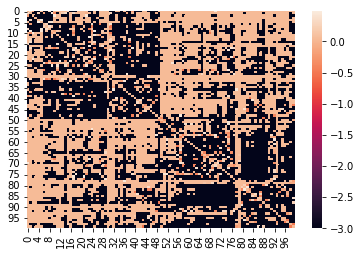

In [199]:
gain_opt_changed[abs(gain_opt_changed) > 0.5] = -3
sns.heatmap(gain_opt_changed)

Run forward model with altered gains:

In [200]:
%%time
res = run_forward_model_newParas(F, g= g_opt, g_EE=g_EE_opt, g_IE=g_IE_opt, 
                                         g_EI=g_EI_opt, std_in= std_in_opt, 
                                         std_out=std_out_opt, w_bb=gain_opt_changed)

0.3229789588563904
CPU times: user 24.6 s, sys: 717 ms, total: 25.4 s
Wall time: 25.2 s


Plot heatmaps and histograms:

(array([  18.,   70.,  222.,  354.,  664.,  774.,  890.,  966.,  996.,
        1004.,  890.,  766.,  740.,  572.,  414.,  292.,  156.,   60.,
          42.,  110.]),
 array([-0.77476753, -0.68602915, -0.59729078, -0.5085524 , -0.41981402,
        -0.33107565, -0.24233727, -0.15359889, -0.06486052,  0.02387786,
         0.11261624,  0.20135461,  0.29009299,  0.37883136,  0.46756974,
         0.55630812,  0.64504649,  0.73378487,  0.82252325,  0.91126162,
         1.        ]),
 <a list of 20 Patch objects>)

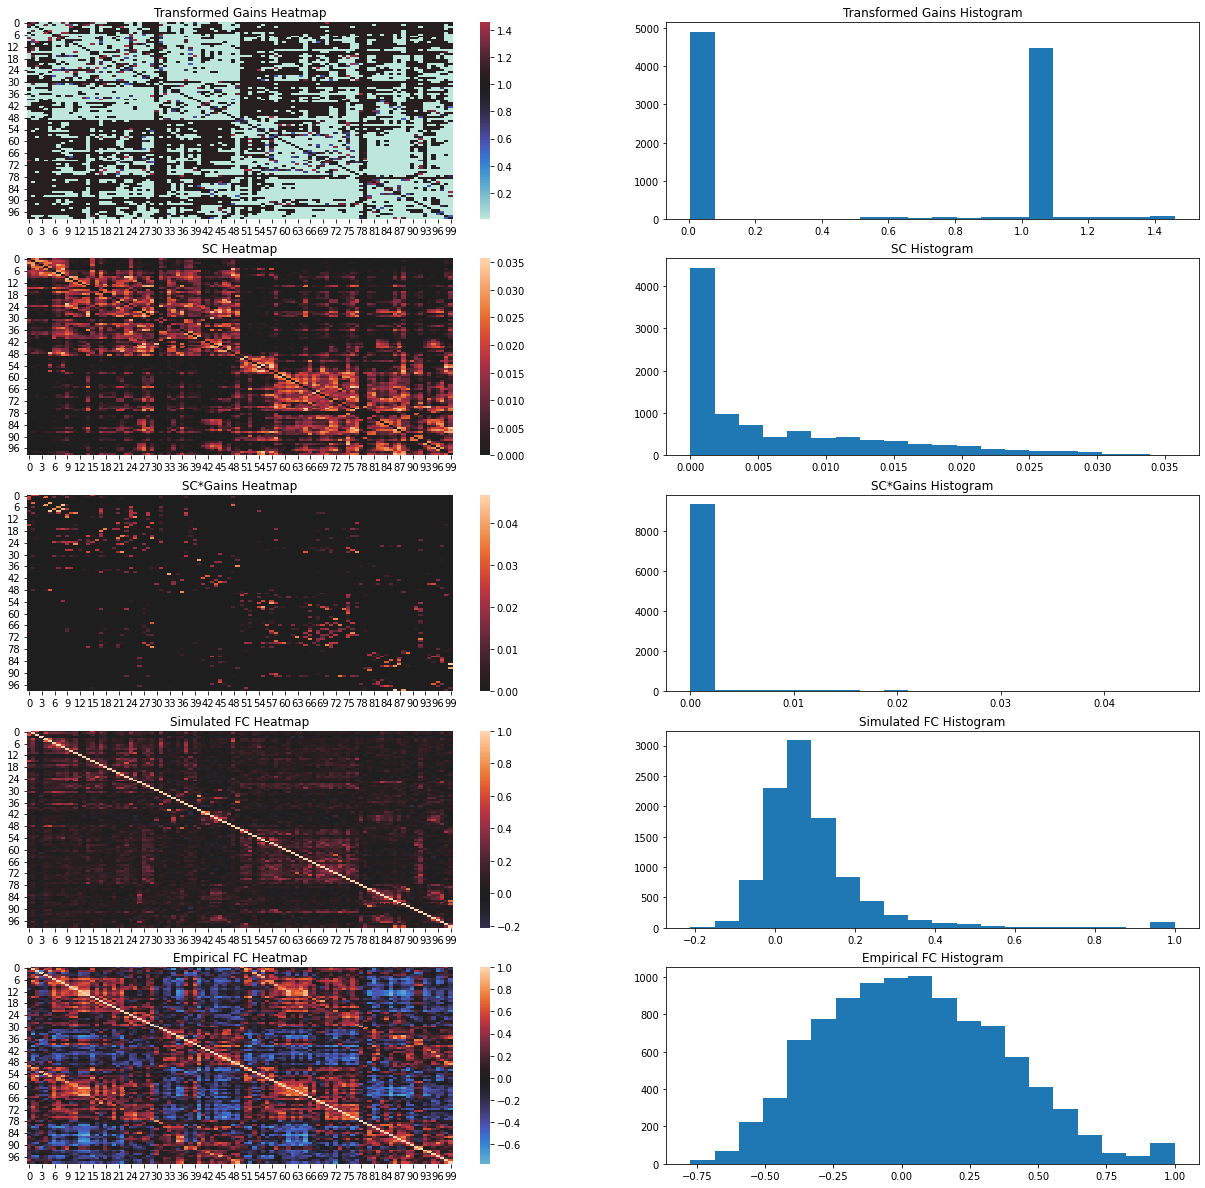

In [201]:
fig, ax = plt.subplots(ncols=2, nrows=5, figsize=(21,21))

trans_gains = np.tanh(gain_opt_changed) + 1
a = ax[0,0]
a.set_title("Transformed Gains Heatmap")
sns.heatmap(trans_gains,center=1,ax=a)
a = ax[0,1]
a.set_title("Transformed Gains Histogram")
a.hist(trans_gains.ravel(),bins=20)
a = ax[1,0]
a.set_title("SC Heatmap")
sns.heatmap(sc,center=0,ax=a)
a = ax[1,1]
a.set_title("SC Histogram")
a.hist(sc.ravel(),bins=20,)
trans_sc = sc * trans_gains
a = ax[2,0]
a.set_title("SC*Gains Heatmap")
sns.heatmap(trans_sc,center=0,ax=a)
a = ax[2,1]
a.set_title("SC*Gains Histogram")
a.hist(trans_sc.ravel(),bins=20)
sim_fc = np.corrcoef(res['simBOLD'])
a = ax[3,0] 
a.set_title("Simulated FC Heatmap")
sns.heatmap(sim_fc,center=0,ax=a)
a = ax[3,1]
a.set_title("Simulated FC Histogram")
a.hist(sim_fc.ravel(),bins=20)
a = ax[4,0]
a.set_title("Empirical FC Heatmap")
sns.heatmap(fc_emp,center=0,ax=a)
a = ax[4,1]
a.set_title("Empirical FC Histogram")
a.hist(fc_emp.ravel(),bins=20)

## Check whether negative correlations in empFC are negative in simFC:

In [183]:
((fc_emp < 0) * (sim_fc <0)).sum()/(fc_emp < 0).sum()

0.41802575107296136

In [186]:
fc_emp[(fc_emp < 0) * (sim_fc <0)].mean()

-0.27068800354121475

In [187]:
fc_emp[fc_emp < 0].mean()

-0.23890639019082985